### BDT Spark Streaming - HW02

#### Assignment

From the data stream, implement a stream processing application that will monitor the delay
of traffic -> where delays are fastest decreasing. Detect the locations where the most traffic 
"spikes" occur repeatedly.

Input: Stream
Output: GPS coordinates of the "fastest delay minimization" locations, dashboard map 
showing these locations

#### My comment on assignment

I found that some of the requirements from assinment were somehow conflicting and vague. Specifically *"where delays are fastest decreasing"* and *"locations where the most traffic 'spikes' occur repeatedly"*.

I solved it in the following way.

###### Fastest decresing criterium
I defined this as 5 percent of the biggest delay decrements.

###### Most traffic spikes occuring repeatedly
I selected top 25 locations with biggest number of samples that fulfill the 'Fastest decreasing' criterium

In [0]:
%pip install osmnx
%pip install numpy==1.23.0

Python interpreter will be restarted.
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Not uninstalling numpy at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-d1122b04-f978-4458-ba58-142bc635f936
    Can't uninstall 'numpy'. No files were found to uninstall.
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.4
    Not uninstalling pandas at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-d1122b04-f978-4458-ba58-142bc635f936
    Can't uninstall 'pandas'. No files were found to uninstall.
  Attempting uninstall: requests
    Found existing installation: requests 2.26.0
    Not uninstalling requests at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-d1122b04-f978-4458-ba58-142bc635f936
    Can't uninstall 'requests'. No files were found to unin

In [0]:
import osmnx as ox
import matplotlib.pyplot as plt

/databricks/python/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### Data selection

I chose to process only data from trams stream, but pretty much the same approach could be applied on other vehicle types. Either separately, or tables could be merged and processed all together.

In [0]:
%sql
DROP TABLE IF EXISTS trams_delays;
CREATE TABLE trams_delays AS
SELECT 
  ROW_NUMBER() OVER(PARTITION BY trip_id ORDER BY timestamp ASC) as trip_msg_order,
  *
FROM
(SELECT 
  cast(properties.last_position.origin_timestamp as timestamp) as timestamp,
  properties.trip.gtfs.trip_id as trip_id,
  cast(geometry.coordinates[0] as double) AS x,
  cast(geometry.coordinates[1] as double) AS y,
  properties.last_position.delay.actual as delay
FROM trams);

-- This query assigns order in which each message was generated for each trip. And also selects crutial information that will be needed later on.
-- I do this so I can compute delay decrement between two consecutive locations for each trip.

num_affected_rows,num_inserted_rows


Out[3]: -62.0

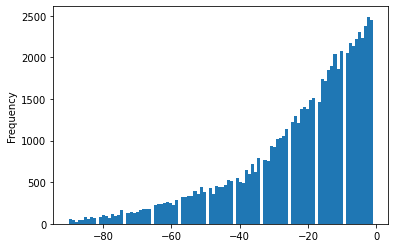

In [0]:
df_delays = spark.sql("SELECT * FROM trams_delays").toPandas()

# select threshold for what "fastest delay minimization" means
# plot negative delays without lowest values, which could be outliers and decide on threshold

df_negative_delays = df_delays[(df_delays['delay'] < 0)]['delay']
# select top 99% to filter out outliers, so the distribution can be clearly plotted
df_cleaned_delays = df_negative_delays[df_negative_delays > df_negative_delays.quantile(q=0.01)]
df_cleaned_delays.plot.hist(bins=100)

# fastest in my context means 5% of fastest delay reductions
biggest_delays_threshold = df_cleaned_delays.quantile(q=0.05)
biggest_delays_threshold

In [0]:
%sql
SELECT
  count(*) as count,
  MIN(delay_delta) as min_delta,
  x, y
FROM
  (SELECT
      T2.x, T2.y,
      (T2.delay - T1.delay) AS delay_delta 
  FROM
  trams_delays T1, trams_delays T2
  WHERE (T1.trip_msg_order + 1) = T2.trip_msg_order and T1.trip_id = T2.trip_id
  ORDER BY delay_delta ASC)
WHERE delay_delta < -62     -- set threshold as stored in biggest_delays_threshold python var
GROUP BY x, y
ORDER BY count DESC
LIMIT 25;

-- In this query delay improvement between each recorded point of each trip is calculated. 
-- Then only top three places where delay decreased most often are selected

count,min_delta,x,y
722,-154,14.40278,50.0719
612,-132,14.42535,50.08165
398,-107,14.29843,50.06534
313,-88,14.41359,50.0847
281,-152,14.40311,50.07194
272,-122,14.32531,50.093
266,-192,14.4819,50.05097
244,-107,14.43335,50.07287
236,-133,14.38247,50.08564
230,-417,14.41964,50.08124


In [0]:
# save results to pandas dataframe
df_results = _sqldf.toPandas()

In [0]:
custom_filter='["highway"~"motorway|motorway_link|trunk|trunk_link|primary|primary_link|secondary|secondary_link|road|road_link"]'
G = ox.graph_from_place("Praha, Czechia", custom_filter=custom_filter)

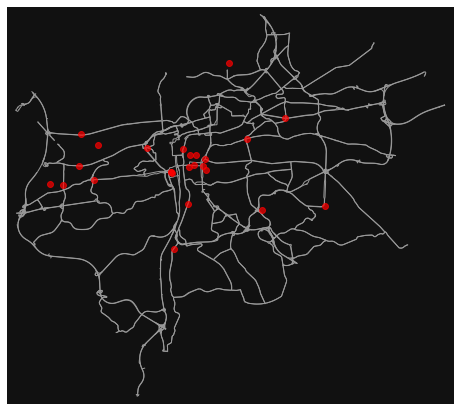

In [0]:
# plot results on map
fig, ax = ox.plot_graph(G, show=False, close=False, node_size=0)
x = df_results['x']
y = df_results['y']
ax.scatter(x, y, c='red', alpha=.7)
plt.show()